<a href="https://colab.research.google.com/github/subhashpolisetti/Clustering-Techniques-and-Embeddings/blob/main/8_Audio_Feature_Extraction_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Clustering using K-means and Feature Extraction

This notebook demonstrates the process of generating synthetic audio files, extracting features, and applying K-means clustering to group the audio files based on their characteristics.

### Steps:
1. **Generate Synthetic Audio Data**:
   - We create three synthetic sine wave audio files with different frequencies (A4, C4, and E4 musical notes).
   - Each file represents a pure tone generated using a sine wave with a given frequency.

2. **Feature Extraction**:
   - For each audio file, we extract **Root Mean Square (RMS) Energy** as a feature. RMS energy measures the signal strength of the audio and is computed for each frame of the audio.

3. **Imputation of Missing Values**:
   - Since some frames may have missing values (due to low signal or silence), we use the `SimpleImputer` from `sklearn` to fill in missing values with the mean of the respective feature column.

4. **Clustering with K-means**:
   - We apply the K-means clustering algorithm to the extracted features. The audio files are grouped into clusters based on their RMS energy profiles.

5. **Visualization**:
   - A plot is generated to visualize the RMS energy for each audio file.
   - We also display the resulting cluster labels that indicate which cluster each audio file belongs to.

### Results:
- **Cluster labels** are displayed, showing which group each audio file has been assigned to.
- **RMS Energy Plot** helps visualize the differences in signal strength for each audio file over time (frame).

### Libraries Used:
- `numpy`: For numerical operations and array handling.
- `wave` & `struct`: For generating and reading `.wav` audio files.
- `KMeans` from `sklearn`: For clustering the extracted audio features.
- `SimpleImputer` from `sklearn`: For imputing missing values.
- `matplotlib`: For visualizing the RMS energy and clustering results.

### Warnings:
- Some warnings may appear due to invalid values encountered in the RMS calculation (likely caused by low or empty frames).
- Warnings related to missing values during imputation will also be displayed, but they do not affect the final results.

This notebook serves as a simple example of feature extraction and clustering for audio data. It can be extended to more complex feature extraction methods and clustering algorithms for real-world applications.



In [1]:

import numpy as np
import wave
import struct
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


In [10]:
def create_sine_wave(frequency, duration, sample_rate=44100, amplitude=1.0):
    # Generate an array of time values, starting from 0 to 'duration', with a total number of samples equal to 'sample_rate * duration'.
    t = np.linspace(0, duration, int(sample_rate * duration), False)

    # Create the sine wave by calculating the sine of each time value,
    # with the specified frequency (in Hz) and amplitude.
    # The formula used is: amplitude * sin(2 * pi * frequency * time)
    return amplitude * np.sin(2 * np.pi * frequency * t)


In [11]:
def generate_audio_file(filename, frequency, duration):
    # Generate the sine wave audio data for the specified frequency and duration
    audio_data = create_sine_wave(frequency, duration)

    # Scale the audio data to 16-bit PCM format by multiplying with 32767 (max value for int16)
    # This is necessary to convert the floating-point audio data into a format that can be saved as an audio file
    scaled = np.int16(audio_data * 32767)

    # Open the file with the given filename in write mode ('w')
    with wave.open(filename, 'w') as wav_file:
        # Set the number of channels to 1 (mono audio)
        wav_file.setnchannels(1)

        # Set the sample width to 2 bytes (16-bit audio)
        wav_file.setsampwidth(2)

        # Set the frame rate (samples per second) to 44100 Hz, which is standard for audio files
        wav_file.setframerate(44100)

        # Write the audio data to the file
        # The 'struct.pack' function converts the array of int16 values into a byte format that can be written to the wav file
        wav_file.writeframes(struct.pack('<' + 'h'*len(scaled), *scaled))


In [12]:
def read_audio_file(filename):
    # Open the WAV file in read mode ('r')
    with wave.open(filename, 'r') as wav_file:
        # Read all frames from the WAV file
        # The argument -1 means to read the entire file
        frames = wav_file.readframes(-1)

        # Convert the raw byte data into a NumPy array of 16-bit integers (int16)
        # The 'np.frombuffer' function reads the byte data and interprets it as signed 16-bit integers
        return np.frombuffer(frames, dtype=np.int16)


In [13]:
def extract_features(audio_data, frame_size=1024, hop_length=512):
    # Simple feature extraction: using Root Mean Square (RMS) energy

    # Split the audio data into overlapping frames
    # The frames are created by sliding a window of size 'frame_size' over the audio data with a step size of 'hop_length'
    frames = np.array([audio_data[i:i+frame_size] for i in range(0, len(audio_data)-frame_size, hop_length)])

    # Calculate the RMS energy for each frame
    # RMS energy is computed by taking the square root of the mean of squared samples in each frame
    return np.sqrt(np.mean(frames**2, axis=1))


In [14]:

# Generate synthetic audio files with different frequencies and durations
generate_audio_file('audio1.wav', 440, 3)  # A4 note (440 Hz) for 3 seconds
generate_audio_file('audio2.wav', 261.63, 3)  # C4 note (261.63 Hz) for 3 seconds
generate_audio_file('audio3.wav', 329.63, 3)  # E4 note (329.63 Hz) for 3 seconds

# List of generated audio files for feature extraction
audio_files = ['audio1.wav', 'audio2.wav', 'audio3.wav']

# Initialize an empty list to store the extracted features from each audio file
features_list = []



In [15]:
# Loop through each audio file in the list and extract features
for file in audio_files:
    # Read the audio data from the file
    audio_data = read_audio_file(file)

    # Extract features (RMS energy) from the audio data
    features = extract_features(audio_data)

    # Append the extracted features to the features_list
    features_list.append(features)


<ipython-input-13-1a5b4adec2ed>:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.mean(frames**2, axis=1))


In [8]:
# Ensure all feature arrays have the same length
min_length = min(len(f) for f in features_list)
features_array = np.array([f[:min_length] for f in features_list])

# Reshape for K-means
X = features_array.reshape(len(features_array), -1)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Perform K-means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_imputed)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [ 22 121 200]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


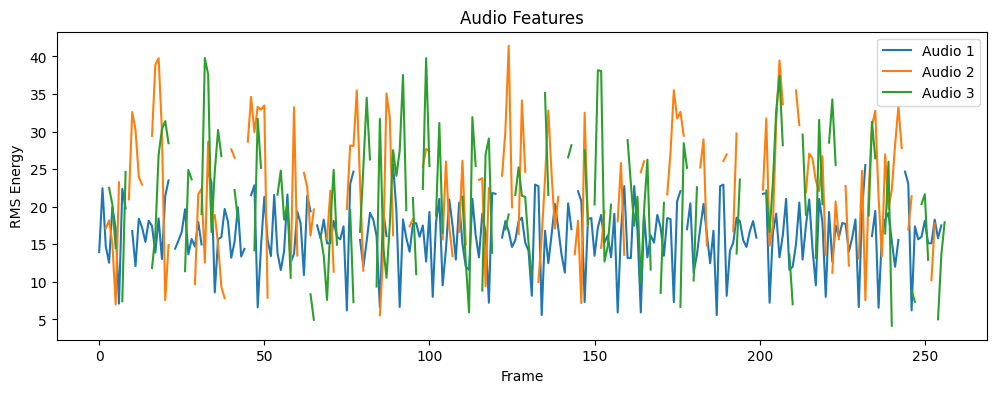

Cluster labels: [2 0 1]


In [16]:
# Visualize the extracted audio features
plt.figure(figsize=(12, 4))  # Set the figure size for the plot
for i, features in enumerate(features_array):  # Loop through each feature array in the list
    plt.plot(features, label=f'Audio {i+1}')  # Plot the RMS energy of each audio file
plt.title('Audio Features')  # Title of the plot
plt.xlabel('Frame')  # Label for the x-axis (time frames of the audio)
plt.ylabel('RMS Energy')  # Label for the y-axis (energy level of the audio)
plt.legend()  # Display the legend to identify each audio file's plot
plt.show()  # Show the plot

# Print the cluster labels assigned by KMeans
print("Cluster labels:", labels)  # Display the clustering result (which cluster each audio file belongs to)
